In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import zipfile
# from natsort import natsorted
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
# from model import VAE

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchmetrics
from dataloader.animal_faces import AnimalfaceDataset


In [3]:
# Load dataset
device = torch.device("cuda")
cpu_device = torch.device("cpu")

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128,128))])
train_data = AnimalfaceDataset(transform=transform)

  0%|                                                                                      | 0/14630 [00:00<?, ?it/s]/data3/home/karmpatel/miniconda3/envs/torch310/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████| 14630/14630 [01:39<00:00, 147.16it/s]


In [5]:
val_data = AnimalfaceDataset(transform=transform, type="val")

100%|███████████████████████████████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 149.03it/s]


In [6]:
BATCH_SIZE = 512
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([512, 3, 128, 128]), torch.Size([512]))

In [7]:
from models.auto_encoder import AutoEncoder, Encoder, Decoder
%reload_ext autoreload
%autoreload 2

In [8]:
# conv_ip_size = (128, 6, 6)
# feature_size = 2048 
# filters = [3,12,24,48,128]
# kernel_sizes = [7, 5, 3, 3]
# strides = [2, 2, 2, 2]
# output_paddings = [1,0,0,1]
# paddings = [0,0,0,0]


feature_size = 2048 
filters = [3, 16]
kernel_sizes = [7]
strides = [2]
output_paddings = [1]
paddings = [0]
return_only_liner = False
feature_size = 2048
dropout_prob = 0.2
if return_only_liner:
    conv_ip_size = (3, 128, 128)
    hidden_sizes = [128*128*3, 128*128, 4096, feature_size]
else:
    conv_ip_size = (16, 61, 61)
    hidden_sizes = [conv_ip_size[0]*conv_ip_size[1]*conv_ip_size[2], 8192, 4096, feature_size]

In [170]:
e = Encoder(enc_op_size=feature_size, conv_op_size=conv_ip_size, filters=filters, 
            kernel_sizes=kernel_sizes,strides=strides, hiddens_sizes=hidden_sizes, 
            return_only_liner=return_only_liner, return_only_conv=0)
op = e(x)
op.shape
summary(e, (3,128,128), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 61, 61]           2,368
              ReLU-2           [-1, 16, 61, 61]               0
           Dropout-3                [-1, 59536]               0
            Linear-4                 [-1, 8192]     487,727,104
              ReLU-5                 [-1, 8192]               0
           Dropout-6                 [-1, 8192]               0
            Linear-7                 [-1, 4096]      33,558,528
              ReLU-8                 [-1, 4096]               0
           Dropout-9                 [-1, 4096]               0
           Linear-10                 [-1, 2048]       8,390,656
Total params: 529,678,656
Trainable params: 529,678,656
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.66
Params size (MB): 2020.56


In [171]:
d = Decoder(dec_ip_size=feature_size, conv_op_size=conv_ip_size, filters=filters[::-1], 
                               kernel_sizes=kernel_sizes[::-1],strides=strides[::-1], output_paddings=output_paddings,
                                 paddings=paddings, hiddens_sizes=hidden_sizes[::-1] , return_only_liner=return_only_liner)
do = d(op)
do.shape
summary(d, (2048,), device="cpu")

[2048, 4096, 8192, 59536]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                 [-1, 2048]               0
            Linear-2                 [-1, 4096]       8,392,704
              ReLU-3                 [-1, 4096]               0
           Dropout-4                 [-1, 4096]               0
            Linear-5                 [-1, 8192]      33,562,624
              ReLU-6                 [-1, 8192]               0
           Dropout-7                 [-1, 8192]               0
            Linear-8                [-1, 59536]     487,778,448
         Unflatten-9           [-1, 16, 61, 61]               0
  ConvTranspose2d-10          [-1, 3, 128, 128]           2,355
             ReLU-11          [-1, 3, 128, 128]               0
Total params: 529,736,131
Trainable params: 529,736,131
Non-trainable params: 0
-------------------------------------------------------------

In [16]:
ae = AutoEncoder(feature_size=feature_size, conv_ip_size=conv_ip_size, filters=filters, 
                 kernel_sizes=kernel_sizes,strides=strides,output_paddings=output_paddings, 
                 paddings=paddings, hiddens_sizes=hidden_sizes, return_only_liner=return_only_liner, droput_prob=dropout_prob).to(device)
op, enc = ae(x.to(device))
print(op.shape, enc.shape)

summary(ae, (3,128,128), device="cuda")

[2048, 4096, 8192, 59536]
torch.Size([512, 3, 128, 128]) torch.Size([512, 2048])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 61, 61]           2,368
              ReLU-2           [-1, 16, 61, 61]               0
           Dropout-3                [-1, 59536]               0
            Linear-4                 [-1, 8192]     487,727,104
              ReLU-5                 [-1, 8192]               0
           Dropout-6                 [-1, 8192]               0
            Linear-7                 [-1, 4096]      33,558,528
              ReLU-8                 [-1, 4096]               0
           Dropout-9                 [-1, 4096]               0
           Linear-10                 [-1, 2048]       8,390,656
          Encoder-11                 [-1, 2048]               0
          Dropout-12                 [-1, 2048]               0
           Linear-13  

In [17]:
show_img = lambda x: plt.imshow(x.permute(0,2,3,1).detach().to(cpu_device).numpy()[0])

In [18]:
%%time
n_epochs = 20
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters(), lr=0.0001)
losses = []
val_losses = []
for epoch in range(n_epochs):
    ae.train()
    tqdm_obj = tqdm(train_loader)
    for i, (X,y) in enumerate(tqdm_obj):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        
        X_hat, enc = ae(X) # [B, feature_size]
        loss = loss_fn(X, X_hat)
        loss.backward()
        optim.step()

        tqdm_obj.set_description_str(f"Epoch: {epoch} Loss {loss}")
        if i%1 == 0:
            losses.append(loss.detach().to(cpu_device))
    
    with torch.no_grad(): # mandatory to write
        ae.eval()
        tqdm_obj = tqdm(val_loader)
        for i, (X,y) in enumerate(tqdm_obj):
            X, y = X.to(device), y.to(device)

            X_hat, enc = ae(X) # [B, feature_size]
            val_loss = loss_fn(X, X_hat)

            tqdm_obj.set_description_str(f"Epoch {epoch} Val Loss {val_loss}")
            if i%1 == 0:
                val_losses.append(val_loss.detach().to(cpu_device))
                

Epoch 19 Val Loss 0.05194208770990372: 100%|███████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]

CPU times: user 1h 21min 5s, sys: 43 s, total: 1h 21min 48s
Wall time: 7min 35s


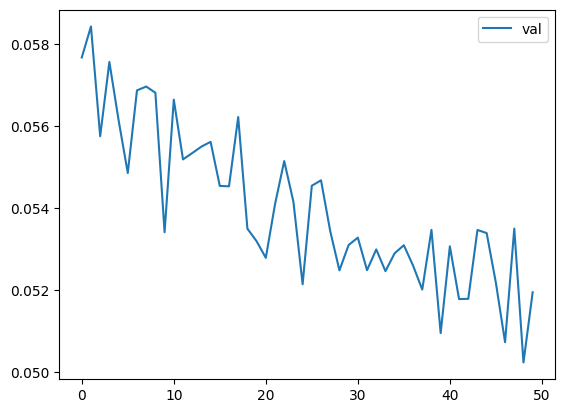

In [19]:
to_cpu = lambda arr: [each.detach().to(cpu_device) for each in arr]
# plt.plot(to_cpu(losses), label="train")
plt.plot(to_cpu(val_losses)[10:], label="val")
plt.legend()

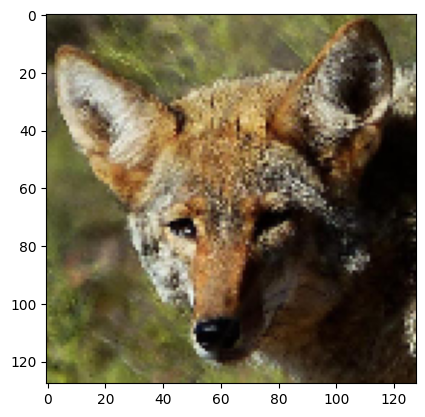

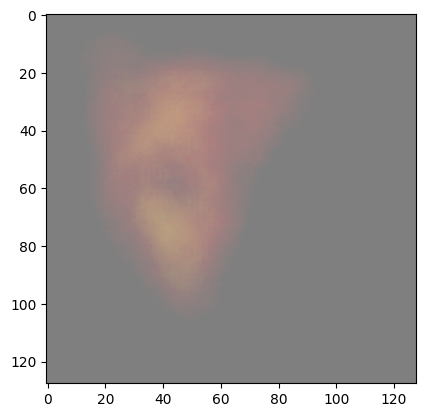

In [21]:
x, y = next(iter(val_loader))
with torch.no_grad():
    ae.eval()
    x_hat, enc = ae(x.to(device))
plt.figure()
show_img(x)
plt.figure()
show_img(x_hat)

### Observations
Effect of kernels size: 
Keep all constant (3)

effect of latent dim:
Try: 2048, 128X6X6

effect of number of filters: Looks like val loss decreasing if we increase number of filters

In [119]:
feature_size

2048

In [120]:
torch.save(ae.state_dict(), f"ckpts/autoencoder_{feature_size}.pt")